In this notebook you will find the most complete applied guide to developing image classification algorithms using Neural Networks. I made myself sure to include the best practices relating the process of developing high accuracy classification algorithms. Everything is covered, from reviewing the data to deploying best practices. I hope you enjoy and learn lots, just as i did.

The goal of this project is to recognice hand gestures from the Alphabet in international sign language. This jupyter notebooks was inspired by the loyal work of my friend Janina, who's work life is focused on helping deaf people to live in a more inclusive society. 

Janina, if you ever read this, the world needs more people like you! ♥

## Needed libraries

In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Importing Data and description

The dataset consists of images, each presented as a reshaped 1D vector version of the image, next to the corresponding category in the "label" column, which labels the sample with a number, ranging from 0 to 24, being 0 letter "A", 1 letter "B" and so on to letter "Y".


Note:   
    
Numbers 9 and 25 are not present in the dataset, which are the labels for letters "J" and "Z", respectively. The reason behind this is that both letters imply movement, impossible to identify with static images.

* Letter "J" is similar to letter i, implying a u-shape movement with the pinky finger

* Letter "Z" is somewhat drawn in the air using the index finger

In [2]:
# A simple mapping relating the label with its corresponding letter
mapping_dict = {}
value = 0
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    if letter in ["J", "Z"]:
        value += 1
        continue
    mapping_dict[letter] = value
    value += 1
inverted_dict = {v: k for k, v in mapping_dict.items()}

In [3]:
train_df = pd.read_csv("datasets/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("datasets/sign_mnist_test/sign_mnist_test.csv")

display("train_df: ", train_df.sample(5))

y_train = train_df[["label"]]
y_test = test_df[["label"]]
del train_df["label"]
del test_df["label"]

print("Labels: ", y_train.label.sort_values().unique())

'train_df: '

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
448,19,197,196,197,197,197,197,198,198,198,...,252,255,255,253,252,250,249,244,202,139
19750,13,228,231,232,233,234,235,236,235,236,...,183,136,91,103,252,254,246,231,253,255
24350,22,73,83,92,100,102,106,112,116,121,...,0,113,191,178,180,178,178,178,175,172
16851,2,170,173,176,179,182,184,187,189,191,...,255,255,255,255,255,255,255,255,255,228
22856,11,193,195,197,201,203,203,205,206,207,...,232,231,231,230,226,223,223,222,218,214


Labels:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


Its important to check visually the differences between the datasets, as it may give an idea of the application context, where the algorithm will be deployed (test set) and how it differs from the available data for training (test set)


Visual comparisons are shown below:

note:

- No evident differences were identified between the training and test sets
- run the image plotting cells as much as you want if you want to check for yourself

#### Training set overview

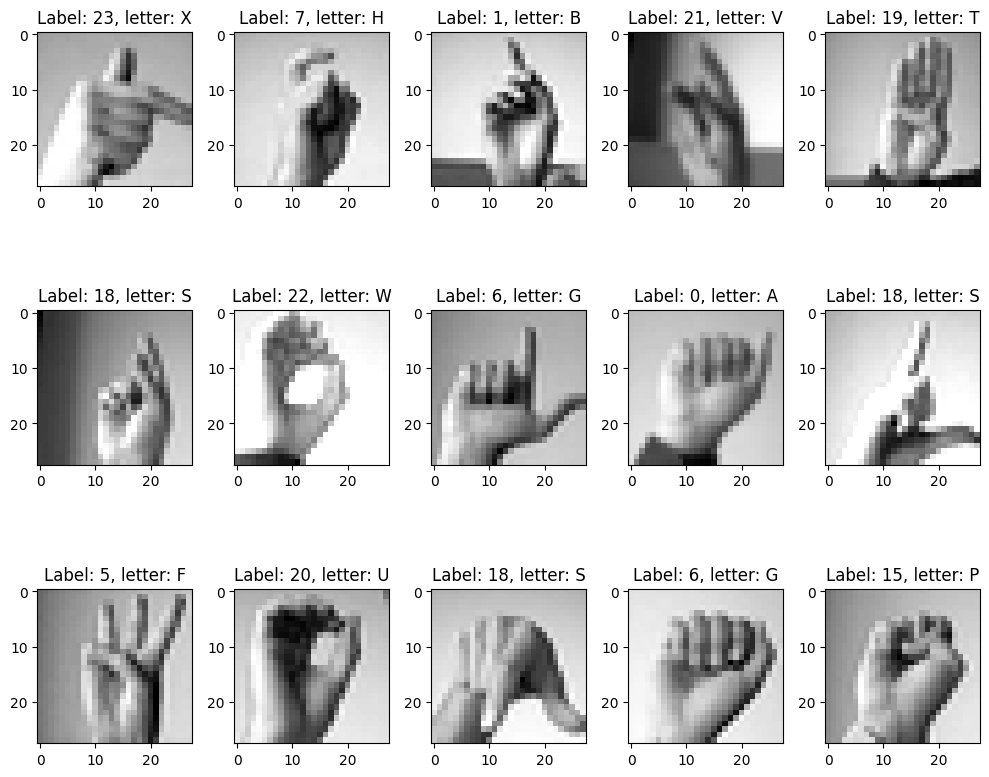

In [60]:
check_on = train_df.values.reshape(-1, 28, 28, 1)
label_on = y_train
n_rows = 3
n_cols = 5

f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0, label_on.shape[0])
        label = label_on[im_idx][0]
        ax[i, j].imshow(check_on[im_idx], cmap="gray")
        ax[i, j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()

#### Test set overview

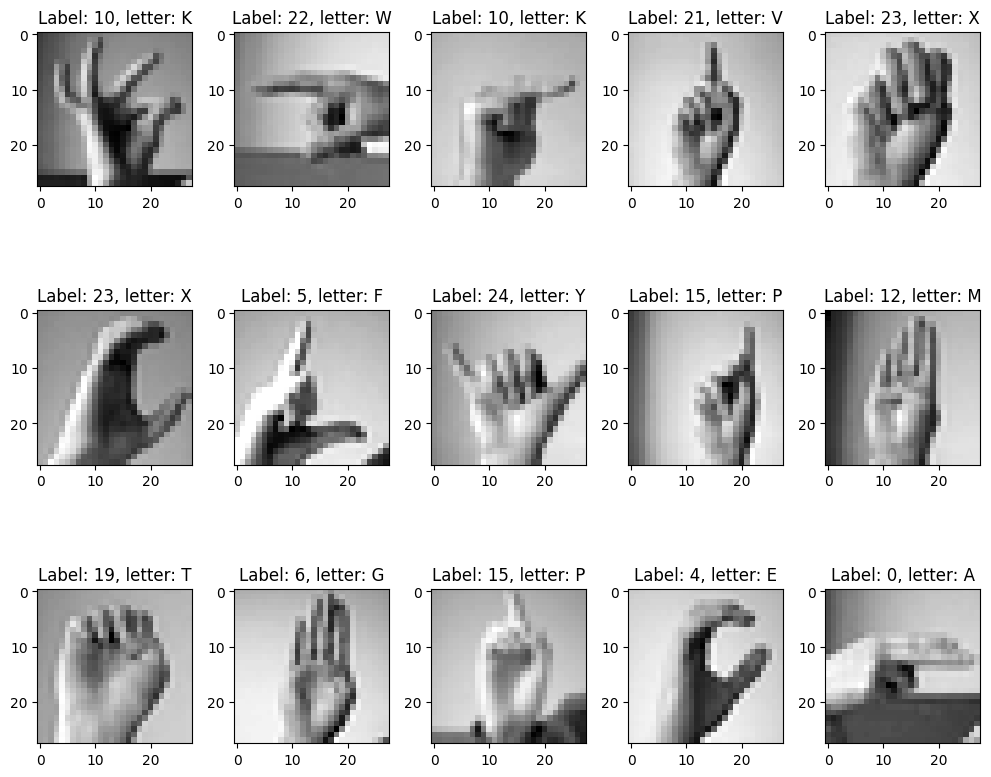

In [61]:
check_on = test_df.values.reshape(-1, 28, 28, 1)
label_on = y_test
n_rows = 3
n_cols = 5

f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0, label_on.shape[0])
        label = label_on[im_idx][0]
        ax[i, j].imshow(check_on[im_idx], cmap="gray")
        ax[i, j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()

## Data Balance

From the rounding 35000 of samples in total, 20% correspond to the training set, which seems appropriate

In [4]:
num_test = y_test.shape[0]
num_train = y_train.shape[0]

num_tot = num_test + num_train
print(f"Total number of samples: {num_tot}")
print(f"percentage of test samples: {100*num_test/num_tot:.2f}%")

Total number of samples: 34627
percentage of test samples: 20.71%


The distribution of categories appears relatively balanced between the training and test sets overall. However, upon closer examination of the bar graph below, it becomes evident that there is a discrepancy in the allocation of data for letters Q and R. Specifically, an imbalance is observed wherein a disproportionate number of samples have been assigned to the training set, while the test set is underrepresented for these particular letters compared to others.

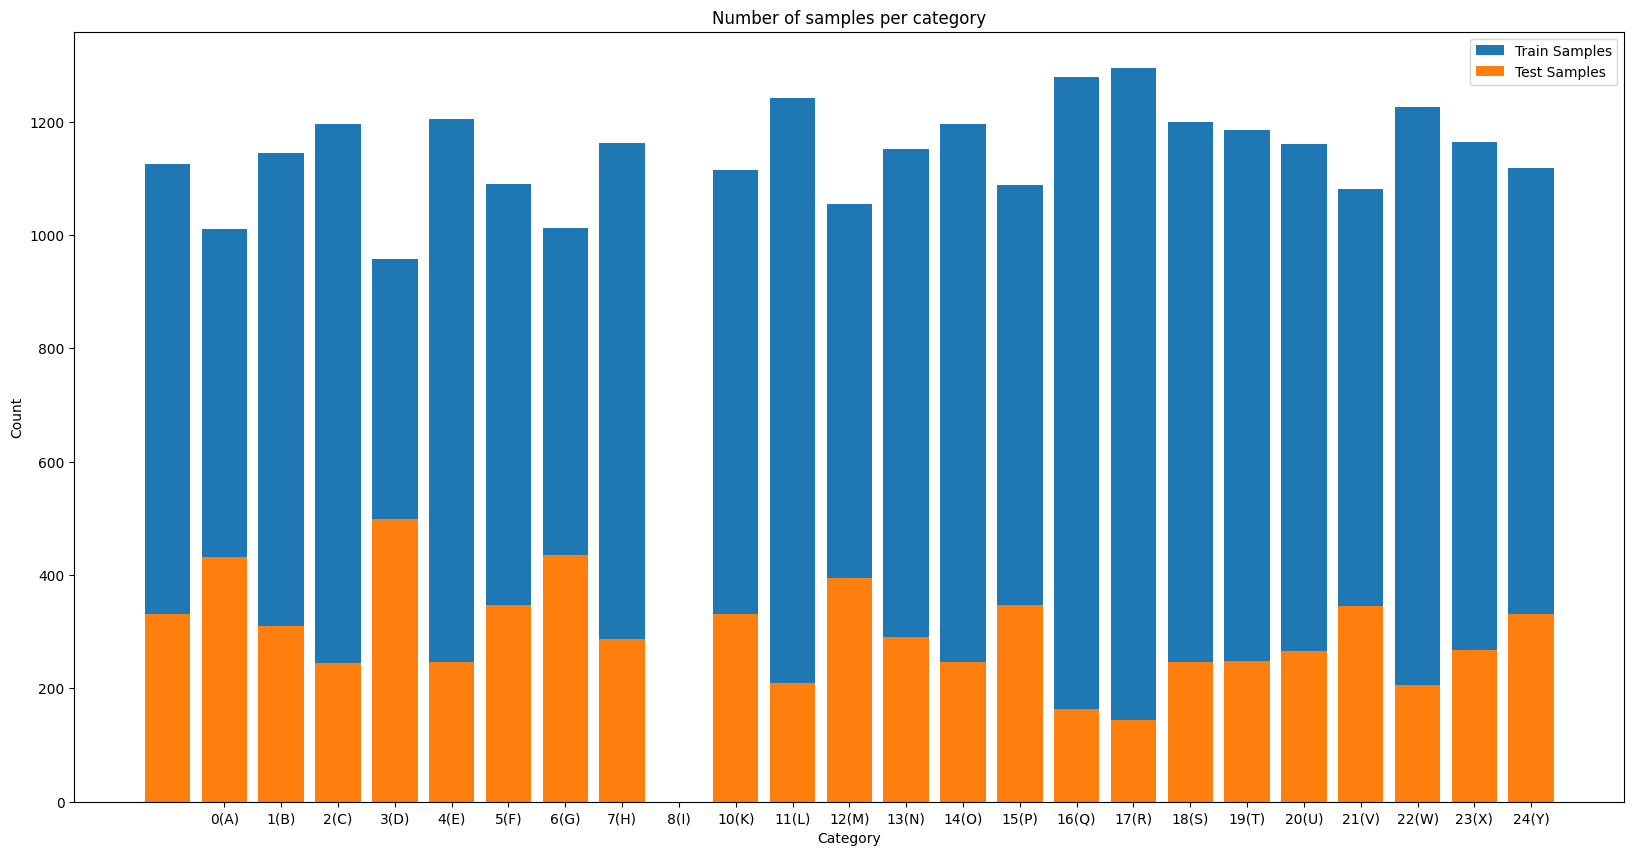

In [24]:
labels = sorted(y_train.label.unique())
labels = [f"{label}({inverted_dict[label]})" for label in labels]
bins = len(labels)

plt.figure(figsize=(20, 10))

train_label_counts = y_train.label.value_counts()
plt.bar(train_label_counts.index, train_label_counts.values, label="Train Samples")
test_label_counts = y_test.label.value_counts()
plt.bar(test_label_counts.index, test_label_counts.values, label="Test Samples")

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of samples per category")
plt.xticks(range(1,len(labels)+1), labels)
plt.legend()

plt.show()

Given the imbalance found above, and since no there is not a special difference between the samples between the training and test samples (as to say that test set approaches more to the final application) both training and test sets will be merged, shuffled, and re-sampled. 

Additionally, I will introduce another dataset for hold-out cross validation (developement set) to decide on diverse hyperparameters and architectures. At the end we will have:

- Training set: For learning
- Dev set: For evaluating the performance of different CNN architectures and hyperparameters
- Test set: For evaluating the best developed model, identified using the dev set

The percentages defined for the splitting are:

Training set: 70%  for training

development set: 15%  To compare between different models and hyperparameters

Test set: 15%  To check final model's performance

In [25]:
full_df = pd.concat([train_df, test_df])
full_y = pd.concat([y_train, y_test])

# Reshape

# (each is a 28x28 pixel image)
num_pixels = int((full_df.shape[1]) ** (1 / 2))

x_full = full_df.values
x_full = x_full.reshape(-1, num_pixels, num_pixels, 1)

# Output as numpy array
y_full = full_y.values

# Splitting of the dataset
x_train, x_devtest, y_train, y_devtest = train_test_split(
    x_full, y_full, train_size=0.7, shuffle=True
)
x_dev, x_test, y_dev, y_test = train_test_split(
    x_devtest, y_devtest, test_size=0.5, shuffle=True
)
total_len = x_full.shape[0]
x_train_len = x_train.shape[0]
x_dev_len = x_dev.shape[0]
x_test_len = x_test.shape[0]
print(f"x_train percentage = {x_train_len/total_len:.02f}")
print(f"x_dev percentage = {x_dev_len/total_len:.02f}")
print(f"x_test percentage = {x_test_len/total_len:.02f}")

x_train percentage = 0.70
x_dev percentage = 0.15
x_test percentage = 0.15


Checking on data balance visually again.

Datasets are now much more balanced.

Note: dev and test set quantities overlaps since both represent equally 15% of the data

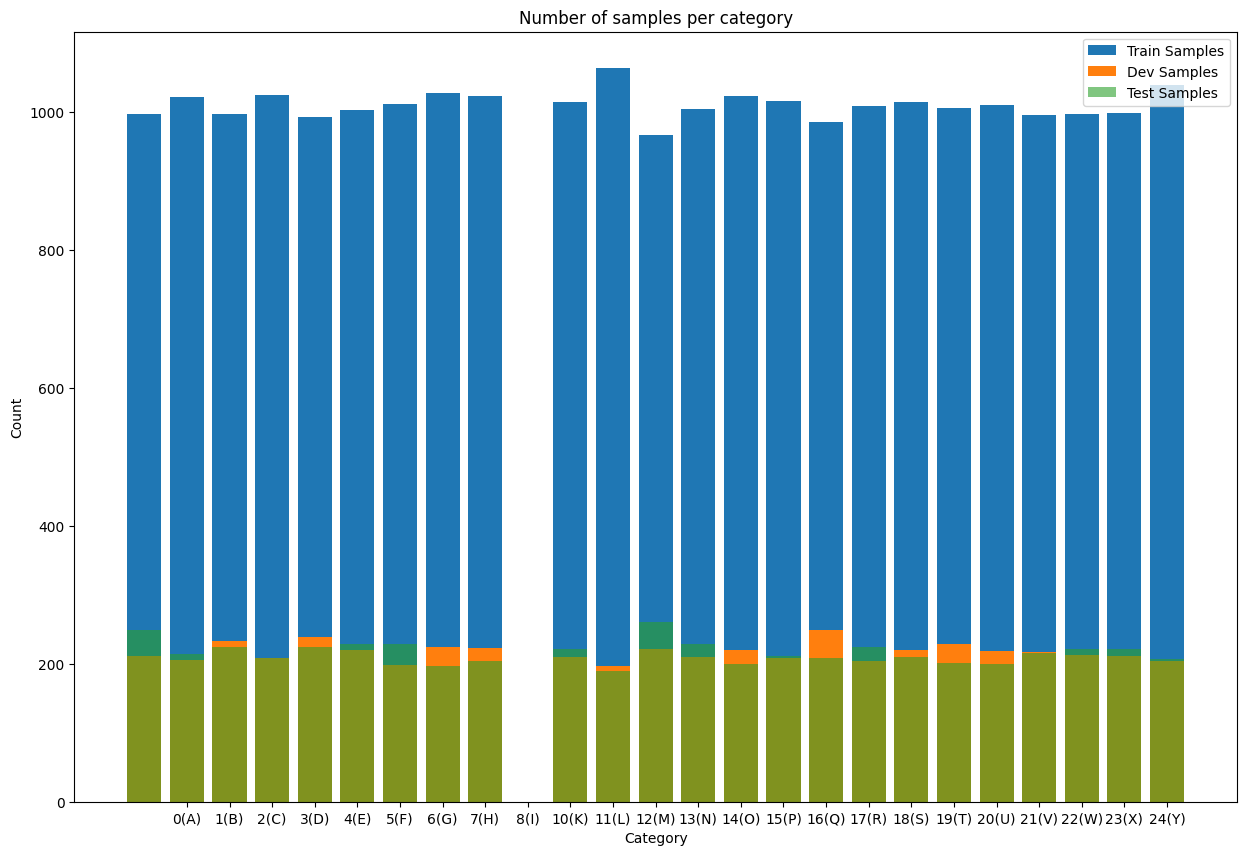

In [33]:
labels = sorted(np.unique(y_train))
labels = [f"{label}({inverted_dict[label]})" for label in labels]

bins = len(labels)

plt.figure(figsize=(15, 10))

train_label_counts = pd.DataFrame(y_train).value_counts()
plt.bar([idx[0] for idx in train_label_counts.index], train_label_counts.values, label="Train Samples")
dev_label_counts = pd.DataFrame(y_dev).value_counts()
plt.bar([idx[0] for idx in dev_label_counts.index], dev_label_counts.values, label="Dev Samples")
test_label_counts = pd.DataFrame(y_test).value_counts()
plt.bar([idx[0] for idx in test_label_counts.index], test_label_counts.values, label="Test Samples", alpha=0.6)


plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of samples per category")
plt.xticks(range(1,len(labels)+1), labels)
plt.legend()

plt.show()

## Training Hyperparameters

### Adjusting the data

#### One-hot ecoding

Its important to adjust the correct labeling for the output labels. 

In this case we have a numerical label for each hand posture, keeping it like this would imply that some gestures have more value than others, which is uncorrect.

This is fixed by one hot encoding the labels

In [62]:
# OUTPUT ENCODING

oh_encoder = OneHotEncoder()

y_train_oh = oh_encoder.fit_transform(y_train).toarray()
y_dev_oh = oh_encoder.fit_transform(y_dev).toarray()
y_test_oh = oh_encoder.fit_transform(y_test).toarray()

#### Data Augmentation

The training data is altered during training to virtually augment the amount of samples, and also making the Neural network performance robust against variations. Its important to make these alterations considering real application scenarios. For example, you would not like to invert upside-down the images, since its very unlikely that people would be sign language talking with spiderman :)

Augmenting the data:

Slight rotation of 20%.

Width and height shift set to 10%

zoom range set to 10%

Brightness was set to range between +/- 25% 

The "fill_mode" parameter was chosen as "nearest" (fills with the nearest pixels), as there is not an important evident pattern to be learned in the images background.

A horizontal flip was included, since the same letters should be equally recognized when performed with the left or the right hand (inclusion means also considering left handed people, or even individuals with missing extremities)

Vertical flip is set to False, since upside down sign communication is not quite a common thing :) 


{'theta': 12.874683540387764,
 'tx': -0.06234038196633434,
 'ty': 1.1156437172484748,
 'shear': 0,
 'zx': 0.9167916581911811,
 'zy': 0.9090497724485725,
 'flip_horizontal': 1,
 'flip_vertical': 0,
 'channel_shift_intensity': None,
 'brightness': 1.1348450001467465}

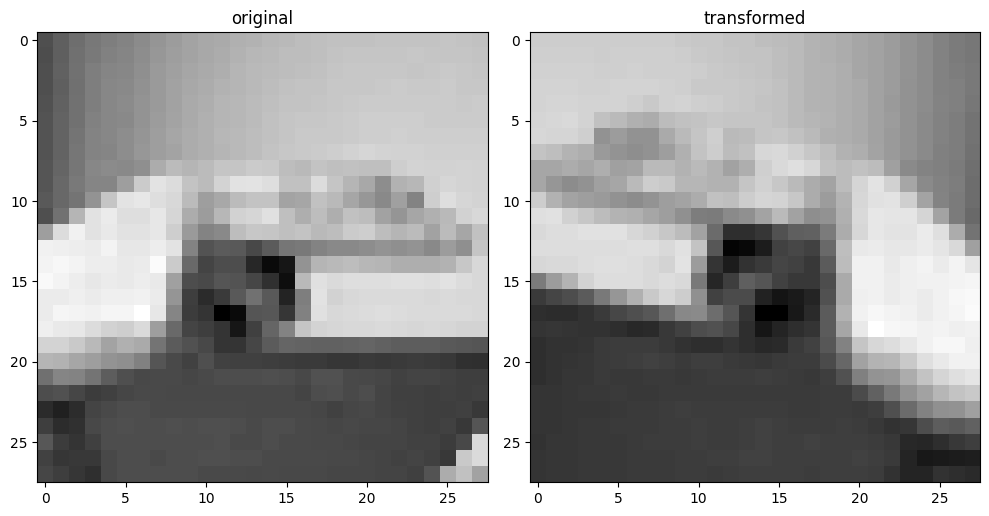

In [63]:
# Data Augmentation

img_gen = ImageDataGenerator(
    rescale=1/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.75, 1.25),
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=False,
)

# Checking in the transformations specified
random_img = np.random.randint(0,x_full.shape[0])
img_sample = x_full[random_img]
img_sample_reshaped = np.expand_dims(img_sample, axis=0)
transform_parameters = img_gen.get_random_transform(img_sample_reshaped.shape)
trans_img = img_gen.apply_transform(img_sample,transform_parameters)

display(transform_parameters)

n_rows = 1
n_cols = 2
f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
ax[0].imshow(img_sample, cmap="gray")
ax[0].set_title("original")
ax[1].imshow(trans_img, cmap="gray")
ax[1].set_title("transformed")
plt.tight_layout()

Defining some training parameters

In [26]:
img_train_gen = img_gen.flow(
    x_train,  # Input numpy array of images
    y_train_oh,  # Corresponding labels
    batch_size=32,  # Batch size
    shuffle=True,  # Shuffle the data
)

reduce_lr = ReduceLROnPlateau(
    monitor="accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)
early_stopping = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

Different models definitions

In [32]:
def sequential_model(input_shape):
    model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.ZeroPadding2D(padding=3, data_format='channels_last'),
            tf.keras.layers.Conv2D(filters=32,kernel_size=(7,7),strides=(1,1)),
            tf.keras.layers.BatchNormalization(axis=3),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(24,activation='softmax')
        ])
    
    return model

In [24]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tf.keras.layers.Conv2D(filters=8,kernel_size=4,strides=1,padding='same')(input_img)
    N1 = tf.keras.layers.BatchNormalization(axis=3)(Z1)
    A1 = tf.keras.layers.ReLU()(N1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2,padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(filters=16,kernel_size=2,strides=1,padding='same')(P1)
    N2 = tf.keras.layers.BatchNormalization(axis=3)(Z2)
    A2 = tf.keras.layers.ReLU()(N2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2,padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    outputs = tf.keras.layers.Dense(units=24,activation='softmax')(F)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

Running the models

In [33]:
seq_model = sequential_model((num_pixels, num_pixels, 1))
seq_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
display(seq_model.summary())
history = seq_model.fit(img_train_gen, epochs=10, batch_size=32, callbacks=[reduce_lr,early_stopping])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_3 (ZeroPadd  (None, 34, 34, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization_6 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 


 re_lu_8 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 24)                150552    
                                                                 
Total params: 152280 (594.84 KB)
Trainable params: 152216 (594.59 KB)
Non-trainable params: 64 (256.00 Byte)
_________________________________________________________________


None

Epoch 1/10
758/758 [==============================] - 16s 19ms/step - loss: 1.8355 - accuracy: 0.4515 - lr: 0.0010
Epoch 2/10
758/758 [==============================] - 12s 16ms/step - loss: 1.0162 - accuracy: 0.6797 - lr: 0.0010
Epoch 3/10
758/758 [==============================] - 13s 17ms/step - loss: 0.8091 - accuracy: 0.7436 - lr: 0.0010
Epoch 4/10
758/758 [==============================] - 13s 16ms/step - loss: 0.6977 - accuracy: 0.7820 - lr: 0.0010
Epoch 5/10
758/758 [==============================] - 12s 16ms/step - loss: 0.6128 - accuracy: 0.8093 - lr: 0.0010
Epoch 6/10
758/758 [==============================] - 13s 17ms/step - loss: 0.5651 - accuracy: 0.8228 - lr: 0.0010
Epoch 7/10
758/758 [==============================] - 13s 16ms/step - loss: 0.5336 - accuracy: 0.8328 - lr: 0.0010
Epoch 8/10
758/758 [==============================] - 13s 17ms/step - loss: 0.4784 - accuracy: 0.8518 - lr: 0.0010
Epoch 9/10
758/758 [==============================] - 14s 18ms/step - loss: 0.45

In [42]:
loss,accuracy = seq_model.evaluate(x_dev/255, y_dev_oh)
print(f"Model seq_model gives {loss} loss and {accuracy} accuracy on the dev set")

163/163 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9315
Model seq_model gives 0.1927664428949356 loss and 0.931459367275238 accuracy on the dev set


In [43]:
conv_model = convolutional_model((num_pixels, num_pixels, 1))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
display(conv_model.summary())
history = conv_model.fit(img_train_gen, epochs=10, batch_size=32, callbacks=[reduce_lr,early_stopping])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 8)         136       
                                                                 
 re_lu_11 (ReLU)             (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 16)        528       
                                                                 
 re_lu_12 (ReLU)             (None, 14, 14, 16)        0         
                                                           

None

Epoch 1/10
758/758 [==============================] - 10s 13ms/step - loss: 2.6024 - accuracy: 0.2403 - lr: 0.0010
Epoch 2/10
758/758 [==============================] - 10s 13ms/step - loss: 1.7139 - accuracy: 0.4847 - lr: 0.0010
Epoch 3/10
758/758 [==============================] - 10s 13ms/step - loss: 1.3545 - accuracy: 0.5841 - lr: 0.0010
Epoch 4/10
758/758 [==============================] - 9s 12ms/step - loss: 1.1522 - accuracy: 0.6384 - lr: 0.0010
Epoch 5/10
758/758 [==============================] - 9s 12ms/step - loss: 1.0164 - accuracy: 0.6802 - lr: 0.0010
Epoch 6/10
758/758 [==============================] - 9s 12ms/step - loss: 0.9314 - accuracy: 0.7084 - lr: 0.0010
Epoch 7/10
758/758 [==============================] - 9s 12ms/step - loss: 0.8568 - accuracy: 0.7291 - lr: 0.0010
Epoch 8/10
758/758 [==============================] - 9s 12ms/step - loss: 0.8162 - accuracy: 0.7426 - lr: 0.0010
Epoch 9/10
758/758 [==============================] - 9s 12ms/step - loss: 0.7710 - a

In [44]:
loss,accuracy = conv_model.evaluate(x_dev/255, y_dev_oh)
print(f"Model conv_model gives {loss} loss and {accuracy} accuracy")

163/163 [==============================] - 0s 1ms/step - loss: 0.2679 - accuracy: 0.9238
Model conv_model gives 0.2679368555545807 loss and 0.9237582087516785 accuracy
